## import

In [1]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.plot import plot_grids
from torchlake.semantic_segmentation.datasets.voc import (LABEL_COLORS,
                                                          VocSegmentation)
from torchlake.semantic_segmentation.models import DaNet
from torchlake.semantic_segmentation.models.pspnet.loss import PspLoss
from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/dual-attention")
data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [5]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(),
        ToTensorV2(),
    ]
)


In [6]:
train_dataset = VocSegmentation(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


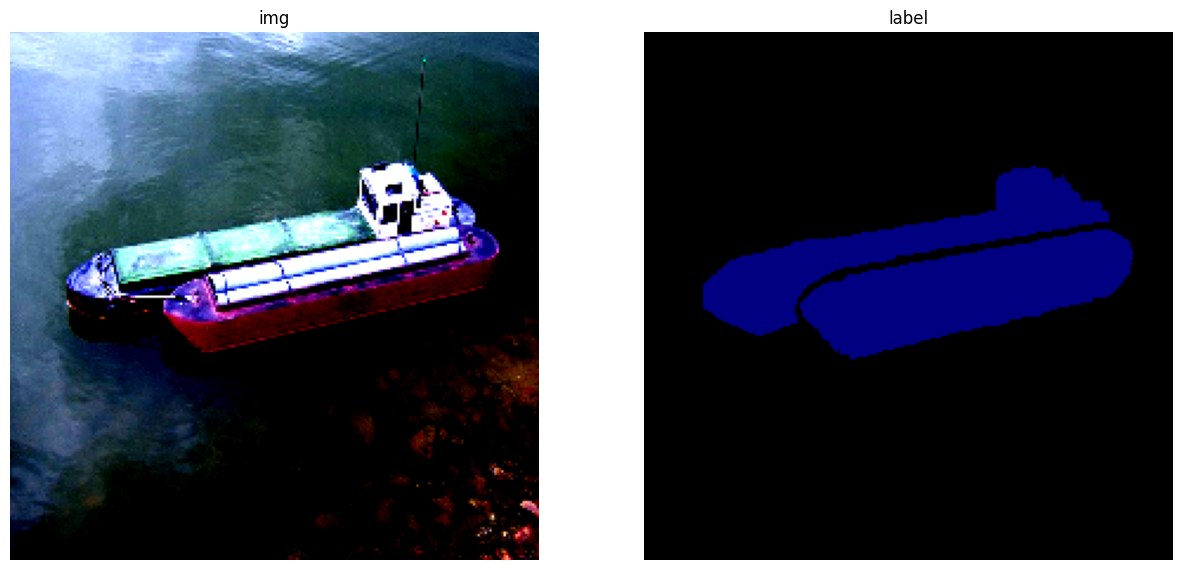

In [8]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

In [9]:
NUM_CLASS = 20

# model

In [10]:
model = DaNet(2048, NUM_CLASS + 1).to(DEVICE)

In [11]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
DaNet                                         --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   75,008
│    │    └─Bottleneck: 3-2                   70,400
│    │    └─Bottleneck: 3-3                   70,400
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   379,392
│    │    └─Bottleneck: 3-5                   280,064
│    │    └─Bottleneck: 3-6                   280,064
│    │    └─Bottleneck: 3-7                   280,064
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   1,512,448
│    │    └─Bottleneck: 3-9                   1,117,184
│    │    └─Bo

In [12]:
model_path = artifacts_path.joinpath('danet.pth')

# train

In [13]:
EPOCHES = 30

In [14]:
criterion = PspLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
model.train()
for e in range(EPOCHES):
    running_loss = 0.0
    for img, label in tqdm(train_loader):
        optimizer.zero_grad()

        img = img.to(DEVICE)
        label = label.long().to(DEVICE)

        output = model(img)
        loss = criterion(*output, label)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"epoch {e+1}: {running_loss/len(train_dataset)}")

100%|██████████| 91/91 [01:04<00:00,  1.40it/s]


epoch 1: 0.044416351004069175


100%|██████████| 91/91 [00:34<00:00,  2.62it/s]


epoch 2: 0.023450315264627528


100%|██████████| 91/91 [00:33<00:00,  2.68it/s]


epoch 3: 0.018744576521604037


100%|██████████| 91/91 [00:33<00:00,  2.71it/s]


epoch 4: 0.016369123701127666


100%|██████████| 91/91 [00:34<00:00,  2.62it/s]


epoch 5: 0.015243912700767007


100%|██████████| 91/91 [00:34<00:00,  2.63it/s]


epoch 6: 0.013009775382646612


100%|██████████| 91/91 [00:33<00:00,  2.74it/s]


epoch 7: 0.011380467941128344


100%|██████████| 91/91 [00:33<00:00,  2.73it/s]


epoch 8: 0.010300127513785973


100%|██████████| 91/91 [00:33<00:00,  2.72it/s]


epoch 9: 0.009758390028412056


100%|██████████| 91/91 [00:33<00:00,  2.72it/s]


epoch 10: 0.009561683063117492


100%|██████████| 91/91 [00:32<00:00,  2.76it/s]


epoch 11: 0.008150375266890324


100%|██████████| 91/91 [00:33<00:00,  2.75it/s]


epoch 12: 0.007760357307356492


100%|██████████| 91/91 [00:32<00:00,  2.76it/s]


epoch 13: 0.007619354913539998


100%|██████████| 91/91 [00:33<00:00,  2.74it/s]


epoch 14: 0.008783745189691957


100%|██████████| 91/91 [00:33<00:00,  2.75it/s]


epoch 15: 0.006507344224221347


100%|██████████| 91/91 [00:32<00:00,  2.76it/s]


epoch 16: 0.006248408413776368


100%|██████████| 91/91 [00:33<00:00,  2.71it/s]


epoch 17: 0.0076186692145858645


100%|██████████| 91/91 [00:34<00:00,  2.65it/s]


epoch 18: 0.009739590640580413


100%|██████████| 91/91 [00:33<00:00,  2.69it/s]


epoch 19: 0.007313828896174839


100%|██████████| 91/91 [00:33<00:00,  2.70it/s]


epoch 20: 0.005828478769710946


100%|██████████| 91/91 [00:33<00:00,  2.69it/s]


epoch 21: 0.0060465115269884556


100%|██████████| 91/91 [00:33<00:00,  2.69it/s]


epoch 22: 0.005060752273792669


100%|██████████| 91/91 [00:32<00:00,  2.80it/s]


epoch 23: 0.004155344729095319


100%|██████████| 91/91 [00:32<00:00,  2.83it/s]


epoch 24: 0.0037010616165356583


100%|██████████| 91/91 [00:32<00:00,  2.83it/s]


epoch 25: 0.0034725695382963537


100%|██████████| 91/91 [00:32<00:00,  2.82it/s]


epoch 26: 0.003284578373699797


100%|██████████| 91/91 [00:33<00:00,  2.69it/s]


epoch 27: 0.0031391756613558196


100%|██████████| 91/91 [00:34<00:00,  2.63it/s]


epoch 28: 0.0030068401368753715


100%|██████████| 91/91 [00:33<00:00,  2.70it/s]


epoch 29: 0.0029223493328832738


100%|██████████| 91/91 [00:32<00:00,  2.83it/s]

epoch 30: 0.00278694083139817


In [16]:
# torch.onnx.export(model, torch.randn(1, 3, 224, 224).cuda(), "fcn.onnx")
torch.save(model.state_dict(), model_path)

In [17]:
get_file_size(model_path)

'116.13MB'

# inference

In [18]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [19]:
test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [20]:
test_dataset = VocSegmentation(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [21]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

### dice coef

In [22]:
model.eval()
with torch.no_grad():
    dice = {class_idx: [] for class_idx in range(21)}
    for img, labels in tqdm(test_loader):
        img = img.cuda()

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        img = img.detach().cpu()

        for class_idx in range(NUM_CLASS+1):
            coef = 2 * (output.eq(class_idx) * labels.eq(class_idx)).sum() / (1 + output.eq(class_idx).sum() + labels.eq(class_idx).sum())
            dice[class_idx].append(coef) 

for k, v in dice.items():
  dice[k] = np.mean(v)

100%|██████████| 92/92 [00:48<00:00,  1.91it/s]


In [23]:
dice.pop(0, "")

# show dice of each category
for k, v in dice.items():
    print(VOC_CLASS_NAMES[k-1], v)

# show all
print("mean dice:", np.mean(list(dice.values())))

aeroplane 0.76638883
bicycle 0.3461541
bird 0.81744766
boat 0.7658865
bottle 0.7136858
bus 0.76948166
car 0.904922
cat 0.8958545
chair 0.7721478
cow 0.67132527
diningtable 0.76442915
dog 0.8862084
horse 0.75167024
motorbike 0.7120264
person 0.9333511
pottedplant 0.62609625
sheep 0.66178393
sofa 0.8263653
train 0.8091785
tvmonitor 0.73022246
mean dice: 0.7562313


### for image in dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


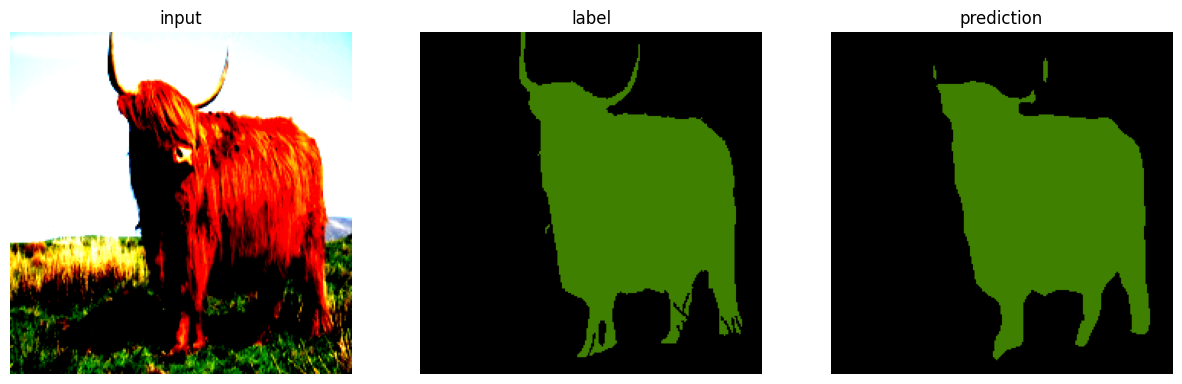

In [24]:
interest_pic = 1523

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image you like

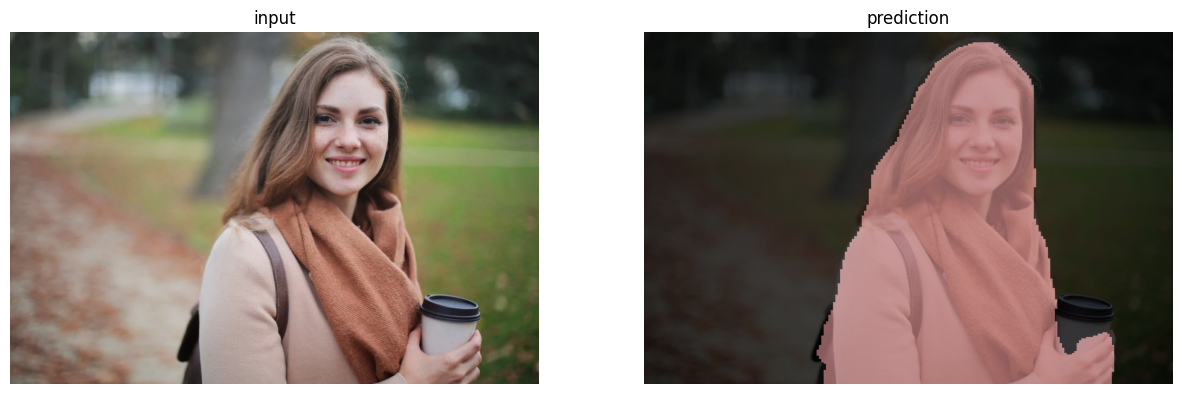

In [25]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )